In [1]:
using CSV, DataFrames

In [6]:
using FixedEffectModels

In [33]:
using Plots

# Uploading CPS data

In [2]:
cps = DataFrame(CSV.File("c:\\data\\Bounds\\cps.csv")) # <-change this to the right directory

## Cleaning zero wage

cps = cps[cps.wage .> 0, :]
first(cps,5)

Row,age,wage,educ
,Int64,Int64,String
1,22,12000,some college but no degree
2,21,3500,some college but no degree
3,49,30000,some college but no degree
4,31,32000,bachelor's degree
5,42,89630,doctorate degree


In [3]:
# Numerical value for education

#1.Creating a dictionary

educ_dict = Dict( 
    "grade 11" => 11, 
    "some college but no degree" => 13, 
    "associate's degree, academic program" => 14,
    "grade 10" => 10, 
    "grades 7 or 8" => 8, 
    "grades 1, 2, 3, or 4" => 4, 
    "associate's degree, occupational/vocational program" => 14, 
    "high school diploma or equivalent" => 12, 
    "grade 9" => 9, 
    "none or preschool" => 0, 
    "doctorate degree" => 21,
    "bachelor's degree" => 16, 
    "master's degree" => 14, 
    "grades 5 or 6" => 6, 
    "professional school degree" => 14, 
    "12th grade, no diploma" => 12
    )

Dict{String, Int64} with 16 entries:
  "grade 11"                                            => 11
  "some college but no degree"                          => 13
  "associate's degree, academic program"                => 14
  "none or preschool"                                   => 0
  "doctorate degree"                                    => 21
  "grade 10"                                            => 10
  "bachelor's degree"                                   => 16
  "master's degree"                                     => 14
  "grades 5 or 6"                                       => 6
  "grades 7 or 8"                                       => 8
  "grades 1, 2, 3, or 4"                                => 4
  "associate's degree, occupational/vocational program" => 14
  "professional school degree"                          => 14
  "high school diploma or equivalent"                   => 12
  "grade 9"                                             => 9
  "12th grade, no diploma"            

In [4]:
#2. transforming cps.educ
f(x) = educ_dict[x]
cps.educ_num = f.(cps.educ)

#3. log of wage
cps.log_wage = log.(cps.wage)
first(cps,3)

Row,age,wage,educ,educ_num,log_wage
,Int64,Int64,String,Int64,Float64
1,22,12000,some college but no degree,13,9.39266
2,21,3500,some college but no degree,13,8.16052
3,49,30000,some college but no degree,13,10.309


In [5]:
Nobs, c = size(cps)
print("The original data contains ", Nobs, " observations and ",c, " columns.")

The original data contains 22715 observations and 5 columns.

# Best Linear Predictor 

In [7]:
#reg(cps, @formula(log_wage ~ educ_num ), Vcov.robust())

In [8]:
#reg(cps, @formula(log_wage ~ educ_num + age ), Vcov.robust())

# Creating Interval Data

In [9]:
using Statistics

In [10]:
wage_quantiles = quantile(cps[!,:wage],[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], sorted=false);
#wage_quantiles[1] +=-1
wage_quantiles[end] +=1

362303.0

In [11]:
lower(x) = wage_quantiles[sum(wage_quantiles .<=x)]
upper(x) = wage_quantiles[sum(wage_quantiles .<=x)+1]

cps.wage_lower = lower.(cps.wage)
cps.wage_upper = upper.(cps.wage)

cps.logwage_lower = log.(cps.wage_lower)
cps.logwage_upper = log.(cps.wage_upper)

first(cps,3)

Row,age,wage,educ,educ_num,log_wage,wage_lower,wage_upper,logwage_lower,logwage_upper
,Int64,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64
1,22,12000,some college but no degree,13,9.39266,9000.0,15000.0,9.10498,9.61581
2,21,3500,some college but no degree,13,8.16052,1.0,9000.0,0.0,9.10498
3,49,30000,some college but no degree,13,10.309,30000.0,36000.0,10.309,10.4913


In [12]:
Nobs, c = size(cps)
print("The complete data contains ", Nobs, " observations and ",c, " columns.")

The complete data contains 22715 observations and 9 columns.

# Partial Indentification

### Reading the module

In [13]:
include("C:\\Users\\The Group Leader\\Notebooks\\Research\\Bounds.jl-1\\src\\setBLP.jl")

Main.setBLP

In [14]:
using Main.setBLP

## Testing oneDproj function

In [15]:
methods(oneDproj)

# 7 methods for generic function "oneDproj":
[1] oneDproj(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Vector{<:Real}) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:196
[2] oneDproj(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real}) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:237
[3] oneDproj(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real}, cord::Int64) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:207
[4] oneDproj(yl::Vector{<:Real}, yu::Vector{<:Real}, x::Matrix{<:Real}, cords::Vector{Int64}) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:220
[5] oneDproj(df::DataFrame, yl::Symbol, yu::Symbol, x::Symbol) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:255
[6] oneDproj(df::DataFrame, yl::Symbol, yu::Symbol, x::Vector{Symbol}) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:263
[7] oneDproj(df::DataFrame, yl::Symbol, yu::Symbol, x::Vector{Symbol}, cord::Int64) in Main.setBLP at C:\Users\The Group Leader\Notebooks\Research\Bounds.jl-1\src\setBLP.jl:271

In [16]:
show(default_options)

Options:
  MC iterations: 2000
  Seed: 15217
  RNG: Random.MersenneTwister(0x53116449c7c199f10e3e2ae60bf43f83)
  Confidence level: 0.95


### 1. Testing the vector/matrix functions

In [17]:
# Preparing vector and matrix versions of the data

yl = cps.logwage_lower;
yu = cps.logwage_upper;
x1 = cps.age;
x2 = cps.educ_num;
x = [x1 x2];

In [18]:
#oneDproj(yl,yu,x1)

In [19]:
#oneDproj(yl,yu,x1)

In [20]:
oneDproj(yl,yu,x,1)

1×2 Matrix{Float64}:
 -0.00905178  0.144324

In [21]:
#oneDproj(yl,yu,x,2)

In [22]:
#oneDproj(yl,yu,x)

### 2. Testing the Dataframe version of the functions

In [23]:
oneDproj(cps,:logwage_lower,:logwage_upper,:age)

1×2 Matrix{Float64}:
 -0.00488786  0.14866

In [24]:
#oneDproj(cps,:logwage_lower,:logwage_upper,:educ_num)

In [25]:
#oneDproj(cps,:logwage_lower,:logwage_upper,[:age,:educ_num],1)

In [26]:
#oneDproj(cps,:logwage_lower,:logwage_upper,[:age,:educ_num],2)

In [27]:
#oneDproj(cps,:logwage_lower,:logwage_upper,[:age,:educ_num])

## Testing CI1d function

In [28]:
res = CI1d(yl,yu,float.(x1),[0, 0.15]);
show(res)

Results: 
  Null: [0.0, 0.15]
  Bound: [-0.0049, 0.1487]
  Htest: 
    Test Stat: 0.7367
    Critical Value: 0.7201
    Confidence Interval: [-0.0097, 0.1534]
  dHtest: 
    Test Stat: 0.202
    Critical Value: 0.597
    Confidence Interval: [-0.0088, 0.1526]


In [29]:
res = CI1d(yl,yu,float.(x1),[0.1,0.15]);
show(res)

Results: 
  Null: [0.1, 0.15]
  Bound: [-0.0049, 0.1487]
  Htest: 
    Test Stat: 15.8082
    Critical Value: 0.681
    Confidence Interval: [-0.0094, 0.1532]
  dHtest: 
    Test Stat: 0.202
    Critical Value: 0.6109
    Confidence Interval: [-0.0089, 0.1527]


In [30]:
res = CI1d(yl,yu,float.(x1),[0.0,0.1]);
show(res)

Results: 
  Null: [0.0, 0.1]
  Bound: [-0.0049, 0.1487]
  Htest: 
    Test Stat: 7.3337
    Critical Value: 0.7369
    Confidence Interval: [-0.0098, 0.1535]
  dHtest: 
    Test Stat: 0.0
    Critical Value: 0.6383
    Confidence Interval: [-0.0091, 0.1529]


In [31]:
res = CI1d(yl,yu,float.(x1),[-0.1,0.15]);
show(res)

Results: 
  Null: [-0.1, 0.15]
  Bound: [-0.0049, 0.1487]
  Htest: 
    Test Stat: 14.3348
    Critical Value: 0.7081
    Confidence Interval: [-0.0096, 0.1534]
  dHtest: 
    Test Stat: 14.3348
    Critical Value: 0.5628
    Confidence Interval: [-0.0086, 0.1524]


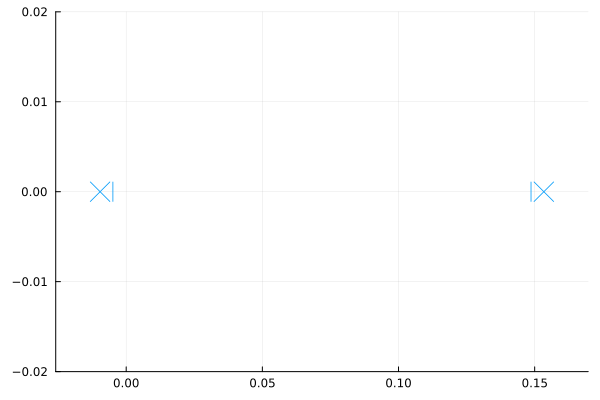

In [47]:
x = [res.Htest.ConfidenceInterval[1],res.bound[1],res.bound[2],res.Htest.ConfidenceInterval[2]]
tol = (x[4]-x[1])/10
y =[0,0,0,0]
symbols =[:x,:vline,:vline,:x]

scatter(x, y, markersize=10, xlim=(x[1]-tol,x[4]+tol), ylim=(-0.02,0.02),marker=symbols,label="")

In [39]:
Shape

Shape